# Entity Resolution: Match Patients in Neptune with Full-Text Search and Amazon OpenSearch Service

This notebook provides a code example for the blog post on entity resolution approaches in Amazon Neptune. In this notebook we explore a patient dataset that links patients to encounters and payers. Our goal is to find similar patients using advanced lexical search.

Lexical search is the ability is find entities with similar text content. For example, patients with names “Walter A. Phillips” and “Philip Allan Walters” having the same date of birth and the same zip code could be resolved to the same patient entity because of their close lexical similarity. 

For lexical similarity, we match patients in a patient graph. We combine Neptune with Amazon OpenSearch Service. 

We use a built-in integration called full-text search or FTS (https://docs.aws.amazon.com/neptune/latest/userguide/full-text-search.html), enabling advanced lexical search of graph. FTS has two key components. One is a poller that synchronizes data from the Neptune database to a separate OpenSearch cluster. The poller runs as a Lambda function, triggered by Neptune Streams when a change is made to the Neptune data. The Lambda function then updates an index in the OpenSearch cluster that maintains a JSON representation of Neptune nodes, edges, or resources, enabling them to be searched on an attribute-by-attribute basis. 

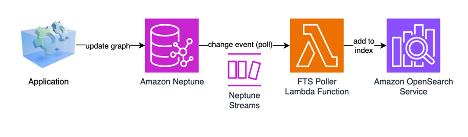
 
FTS also allows combined queries of Neptune and OpenSearch. In a query to the Neptune database (in either Gremlin or SPARQL), an application can implicitly bring back from the OpenSearch nodes, edges, or resources that lexically match on specified criteria. The query may then do further traversal to find additional detail. 

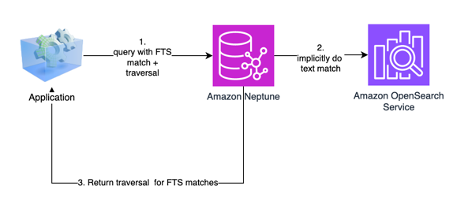
 
Combined query enables us in one shot to find patients with a name similar to a given pattern but also to traverse in the graph to find related payer, encounter, and payer details that provide additional verification of a match. We could use this in two cases: to match a new patient to existing patients on file; to match and link existing patients to each other.

## Data set

We use the following dataset: https://synthea.mitre.org/downloads

Jason Walonoski, Mark Kramer, Joseph Nichols, Andre Quina, Chris Moesel, Dylan Hall, Carlton Duffett, Kudakwashe Dube, Thomas Gallagher, Scott McLachlan, Synthea: An approach, method, and software mechanism for generating synthetic patients and the synthetic electronic health care record, Journal of the American Medical Informatics Association, Volume 25, Issue 3, March 2018, Pages 230–238, https://doi.org/10.1093/jamia/ocx079

Our patient model is the following:

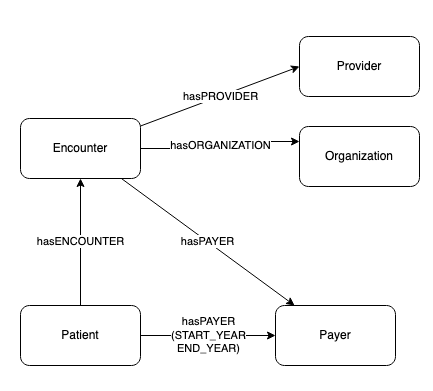

We have already prepared the data and staged in a public S3 bucket. If you are curious to see how we prepared the data, see notebook EntityResolutionDataPrep.ipynb.

## Setup

1. Create a Neptune cluster version 1.2.1.x or higher in a supported region. Use https://docs.aws.amazon.com/neptune/latest/userguide/get-started-cfn-create.html to automate setup using CloudFormation. Make sure to setup a notebook too by setting the NotebookInstanceType parameter.

2. In the same region, create an OpenSearch domain from Amazon OpenSearch Service console. A single AZ domain suffices. Disable Fine-Grained Access Control. Place the domain in the same VPC and subnets as the Neptune cluster. You can locate Neptune's VPC and subnets in the Outputs section of the CloudFormation stack used to create the Neptune cluster.

3. Deploy the Neptune Full-Text Search (FTS) stack, linked from https://docs.aws.amazon.com/neptune/latest/userguide/full-text-search-cfn-create.html. Several parameters are required, including the OpenSearch cluster endpoint and various details about the Neptune cluster.

4. Enable streams on the Neptune cluster. In the cluster parameter group by your Neptune cluster, set parameter neptune_streams to 1. This is a static parameter, so restart the cluster to take effect.

5. Bulk-load the patient data. This takes a few minutes. Check status for no errors. 

6. Run queries. 


## Add your Amazon OpenSearch Service endpoint
Replace the value here with your own instance.

In [ ]:
AOS_ENDPOINT = "https://vpc-fts-pg-w7gxu44cuvn4lsht4td3z5wghi.us-east-1.es.amazonaws.com"
# TODO add yours

## Bulk load patient data
The data was prepared for you, staged in a public S3 bucket. Run Neptune's bulk loader to ingest it into Neptune. As it is loaded, Neptune streams tracks each insert. The Neptune FTS poller listens to the stream and writes documents to the AOS cluster accordingly.

Run the %load first. It takes a few minutes. Then check results by running %load_status.


In [ ]:
%load -s s3://aws-neptune-customer-samples/neptune-ent-res/patients/pg --store-to loadres --run

In [ ]:
%load_status {loadres['payload']['loadId']} --errors --details

## Explore dataset
Patients, their encounters and payers. It's helpful to look at the Graph tab.

In [ ]:
%%gremlin

g.V().hasLabel('Patient').out('hasENCOUNTER').path().by(elementMap()).limit(100)


In [ ]:
%%gremlin

g.V().hasLabel('Patient').outE('hasPAYER').inV().path().by(elementMap()).limit(100)


## Try FTS query: query AOS as part of a graph query in Gremlin

### Something like prosecco for Patient last name

In [ ]:
%%gremlin

g.withSideEffect("Neptune#fts.endpoint",'${AOS_ENDPOINT}')
  .V().hasLabel("Patient").has("LAST","Neptune#fts prosecco~").elementMap('LAST')



### Something like prosecco in any Patient property
In some results, it's in LAST name, it others ADDRESS.

In [ ]:
%%gremlin

g
.withSideEffect("Neptune#fts.endpoint", '${AOS_ENDPOINT}')
.withSideEffect("Neptune#fts.queryType", "query_string")
.withSideEffect("Neptune#fts.sortOrder", "asc")
  .V().hasLabel("Patient").has("*","Neptune#fts prosecco~").elementMap()



### Try a more advanced query string

Apache Lucene syntax:

predicates.LAST.value:(town~ OR havey~) OR predicates.MAIDEN.value:(town~ OR havey~)

So, consider LAST or MAIDEN names having a fuzzy match on town or havey

Notice matches include Harvey and Towne


In [ ]:
query_string="Neptune#fts predicates.LAST.value:(havey~ OR town~) OR predicates.MAIDEN.value:(havey~ OR town~)"


In [ ]:
%%gremlin

g
.withSideEffect("Neptune#fts.endpoint", '${AOS_ENDPOINT}')
.withSideEffect("Neptune#fts.queryType", "query_string")
.withSideEffect("Neptune#fts.sortOrder", "asc")
.V().hasLabel("Patient")
.has("*", '${query_string}')
.elementMap()




In [ ]:
%%gremlin --store-to results

g
.withSideEffect("Neptune#fts.endpoint", '${AOS_ENDPOINT}')
.withSideEffect("Neptune#fts.queryType", "query_string")
.withSideEffect("Neptune#fts.sortOrder", "asc")
.V().hasLabel("Patient")
.has("*", '${query_string}')

.project('patient', 'encounters', 'payers')
    .by(elementMap())
    .by(out('hasENCOUNTER').elementMap().fold())
    .by(outE('hasPAYER').as('pt').inV().as('payer').select('pt', 'payer').by(elementMap()).fold())


### Same, but bring in payers and encounters for each patient match
FTS is used for name matching on patient. If there is lexical similarity, we want to also inspect surrounding nodes. 

Example: patient is being admitted. Now we can ask them who their payer is, or if they can describe any other encounters they've had.


### Similar, but include encounter check too

In [ ]:
encounter_query_string="Neptune#fts predicates.REASONDESCRIPTION.value:hyperlipidemia~"


In [ ]:
%%gremlin

g
.withSideEffect("Neptune#fts.endpoint", '${AOS_ENDPOINT}')
.withSideEffect("Neptune#fts.queryType", "query_string")
.withSideEffect("Neptune#fts.sortOrder", "asc")
.V().hasLabel("Patient")
.has("*", '${query_string}')
.as('patient')
.out('hasENCOUNTER')
.has("*", '${encounter_query_string}')
.as('encounter')
.select('patient', 'encounter')
.by(elementMap())

### Find First-Last Matches
Notice seach for Raye Wyman returns two patients. Same SSN, same ZIP. 

In [ ]:
fl_query_string = "Neptune#fts predicates.FIRST.value:raye~ AND predicates.LAST.value:wyman~"


In [ ]:
%%gremlin

g
.withSideEffect("Neptune#fts.endpoint", '${AOS_ENDPOINT}')
.withSideEffect("Neptune#fts.queryType", "query_string")
.withSideEffect("Neptune#fts.sortOrder", "asc")
.V().hasLabel("Patient")
.has("*", '${fl_query_string}')
.elementMap('FIRST', 'LAST', 'ZIP', 'SSN')

### Match these patients

In [ ]:
%%gremlin

g.addE('matches')
.from(V('http://example.org/patientgraph/patient/3e7c92d1-3c0d-485d-8289-154750bd5770'))
.to(V('http://example.org/patientgraph/patient/x3e7c92d1-3c0d-485d-8289-154750bd5770'))
.property("matchSource", "user").property("matchAlg", "fts")

In [ ]:
%%gremlin

g.E().hasLabel('matches').elementMap()

## Opensearch stuff
This section is optional, if you would like to directly interact with OpenSearch. Ensure your notebook instance's IAM role has policies allowing acccess to the AOS cluster.

In [ ]:
!pip install -q opensearch-py

In [ ]:
import boto3
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

aos_client = OpenSearch(
    hosts = [{'host': AOS_ENDPOINT.split("//")[1], 'port': 443}],
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)


### List the indexes
FTS uses amazon_neptune

In [ ]:
aos_client.indices.get_alias(index="*")


In [ ]:
aos_client.indices.get(index="amazon_neptune")

### Delete the Neptune index (Cleanup only!)

In [ ]:
aos_client.indices.delete(index="amazon_neptune")


### Run queries
If you wanted to query AOS on its own, without going through Neptune FTS, here is an example.

In [ ]:
query = {
 "query": {
    "query_string": {
      "query": "predicates.LAST.value:(perez~ OR havey~ OR abott~) OR predicates.MAIDEN.value:(perez~ OR havey~ OR abott~)"
    }
  }
}

res = aos_client.search(index="amazon_neptune", body=query)
res


## View Neptune streams 
Useful after your run the bulk load to view what's in the stream. Neptune uses stream to write to AOS.

In [ ]:
%stream_viewer